In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## 样本生成

生成两组环形样本。

下面代码中`tf.random.truncated_normal`是截断的正态分布，截掉了所有$\vert x-\mu\vert > 2\sigma$的数。正负样本分布半径范围分别为：$(3,7),\ (6,10)$

In [3]:
# 正、负样本
n_positive, n_negative = 2000, 2000

In [34]:
# 正样本
r_p = 5.0 + tf.random.truncated_normal([n_positive, 1], 0.0, 1.0)
theta_p = tf.random.uniform([n_positive, 1], 0.0, 2*np.pi)
Xp = tf.concat([r_p * tf.cos(theta_p), r_p * tf.sin(theta_p)], axis=1)
Yp = tf.ones_like(r_p)

In [33]:
# 负样本
r_n = 8.0 + tf.random.truncated_normal([n_negative, 1], 0.0, 1.0)
theta_n = tf.random.uniform([n_negative, 1], 0.0, 2*np.pi)
Xn = tf.concat([r_n * tf.cos(theta_n), r_n * tf.sin(theta_n)], axis=1)
Yn = tf.zeros_like(r_n)

In [44]:
X = tf.concat([Xp, Xn], axis=0)
Y = tf.concat([Yp, Yn], axis=0)

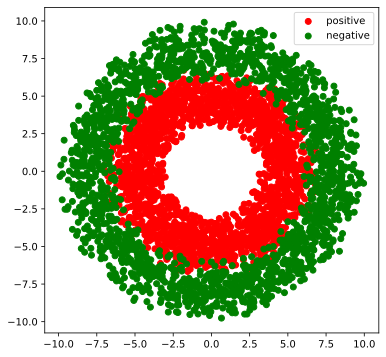

In [13]:
# 可视化
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0], Xp[:, 1], c='r')
plt.scatter(Xn[:, 0], Xn[:, 1], c='g')
plt.legend(['positive', 'negative'])

## 构建数据管道

将数据分批，且以生成器形式输出。

下面构造每批数量为16的数据管道。

In [76]:
def data_gen(features, labels, batch_size=16):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        index = indices[i:min(i+batch_size, num_examples)]
        yield tf.gather(features, index), tf.gather(labels, index)

In [46]:
# 测试数据管道效果
batch_size = 10
gen_xp = data_gen(X, Y, batch_size)
(features, labels) = next(gen_xp)
features, labels

0


(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[-0.6702242,  8.757102 ],
        [-2.989344 , -4.5696   ],
        [-2.3214822, -4.006882 ],
        [-0.6727293, -5.3206286],
        [-4.2663074,  5.969737 ],
        [-3.0069277, -3.0342867],
        [ 1.3063998, -8.701153 ],
        [-4.939461 , -1.6661509],
        [-1.5862302, -4.5522532],
        [ 2.0658972,  4.82826  ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.]], dtype=float32)>)

## 模型定义

通过继承`tf.Module`，实现自定义模型

模型设定：

- 三层神经网络，层数分别是：$2, 4, 8, 1$
- 隐藏层使用relu激活函数，输出层使用sigmoid激活函数
- 使用He参数初始化
- 损失函数使用二元交叉熵
- 评估指标为准确率

In [72]:
class DNNModel(tf.Module):
    def __init__(self, name=None):
        super().__init__()
        self.w1 = tf.Variable(tf.random.normal([2, 4], dtype=tf.float32) * tf.sqrt(1/2) )
        self.b1 = tf.Variable(tf.zeros([1, 4]), dtype=tf.float32)
        self.w2 = tf.Variable(tf.random.normal([4, 8], dtype=tf.float32) * tf.sqrt(1/4) )
        self.b2 = tf.Variable(tf.zeros([1, 8]), dtype=tf.float32)
        self.w3 = tf.Variable(tf.random.normal([8, 1], dtype=tf.float32) * tf.sqrt(1/8))
        self.b3 = tf.Variable(tf.zeros([1, 1]), dtype=tf.float32)
    
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])
    def __call__(self, x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3 + self.b3)
        return y
    
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)])
    def loss_func(self, y_true, y_pred):
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        loss = - y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
        return tf.reduce_mean(loss)
    
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)]) 
    def metric_func(self, y_true, y_pred):
        y_pred = tf.where(y_pred>0.5, tf.ones_like(y_pred, dtype=tf.float32), tf.zeros_like(y_pred, dtype=tf.float32))
        acc = tf.reduce_mean(1-tf.abs(y_true-y_pred))
        return acc

In [82]:
model = DNNModel()
batch_size = 16
(features, labels) = next(data_gen(X, Y, batch_size))
predictions = model(features)

loss = model.loss_func(labels, predictions)
metric = model.metric_func(labels, predictions)

tf.print("init loss:", loss)
tf.print("init metric:", metric)

init loss: 0.673768878
init metric: 0.5


## 训练模型

In [85]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    
    for p, dp in zip(model.trainable_variables, grads):
        p.assign(p - 0.001*dp)
    
    metric = model.metric_func(labels, predictions)
    
    return loss, metric

def train_model(model, epochs):
    for epoch in tf.range(1, epochs+1):
        for features, labels in data_gen(X, Y, 100):
            loss, metric = train_step(model, features, labels)
        if epoch % 100 == 0:
            print("=============")
            tf.print('epoch=', epoch, 'loss=',loss, 'accuracy=', metric)

In [89]:
train_model(model, epochs=2000)
print('========\n', 'training finished!')

epoch= 100 loss= 0.344931453 accuracy= 0.94
epoch= 200 loss= 0.317041904 accuracy= 0.89
epoch= 300 loss= 0.266672522 accuracy= 0.96
epoch= 400 loss= 0.214894429 accuracy= 0.94
epoch= 500 loss= 0.228197977 accuracy= 0.9
epoch= 600 loss= 0.198814437 accuracy= 0.92
epoch= 700 loss= 0.206341565 accuracy= 0.91
epoch= 800 loss= 0.156920657 accuracy= 0.95
epoch= 900 loss= 0.139830574 accuracy= 0.97
epoch= 1000 loss= 0.108117014 accuracy= 0.97
epoch= 1100 loss= 0.190057322 accuracy= 0.91
epoch= 1200 loss= 0.119872816 accuracy= 0.97
epoch= 1300 loss= 0.0855327398 accuracy= 0.99
epoch= 1400 loss= 0.18146053 accuracy= 0.93
epoch= 1500 loss= 0.131447643 accuracy= 0.95
epoch= 1600 loss= 0.0851939097 accuracy= 0.99
epoch= 1700 loss= 0.113292053 accuracy= 0.97
epoch= 1800 loss= 0.137741476 accuracy= 0.93
epoch= 1900 loss= 0.154394165 accuracy= 0.92
epoch= 2000 loss= 0.11693836 accuracy= 0.96
 training finished!


## 结果可视化

Text(0.5, 1.0, 'y_pred')

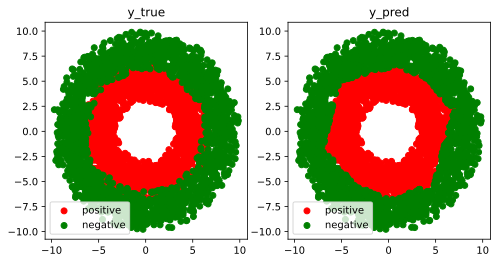

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.scatter(Xp[:, 0], Xp[:, 1], c='r')
ax1.scatter(Xn[:, 0], Xn[:, 1], c='g')
ax1.legend(['positive', 'negative'])
ax1.set_title('y_true')

Xp_pred = tf.boolean_mask(X, tf.squeeze(model(X)>=0.5), axis=0)
Xn_pred = tf.boolean_mask(X, tf.squeeze(model(X)<0.5), axis=0)

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c='r')
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c='g')
ax2.legend(['positive', 'negative'])
ax2.set_title('y_pred')